In [2]:
!pip install monai
!pip3 install nibabel
!pip3 install torch
!pip3 install sklearn
!pip3 install tqdm

Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
Defaulting to user installation because normal site-packages is not writeable
  Using cached sklearn-0.0.post12.tar.gz (2.6 kB)
  Preparing metadata (setup.py) ... error
  error: subprocess-exited-with-error
  
  × python setup.py egg_info did not run successfully.
  │ exit code: 1
  ╰─> [15 lines of output]
      The 'sklearn' PyPI package is deprecated, use 'scikit-learn'
      rather than 'sklearn' for pip commands.
      
      Here is how to fix this error in the main use cases:
      - use 'pip install scikit-learn' rather than 'pip install sklearn'
      - replace 'sklearn' by 'scikit-learn' in your pip requirements files
        (requirements.txt, setup.py, setup.cfg, Pipfile, etc ...)
      - if the 'sklearn' package is used by one of your depende

In [3]:
import os
import shutil
import matplotlib.pyplot as plt
import PIL
import torch
from torch.utils.tensorboard import SummaryWriter
import numpy as np
from monai.config import print_config
from monai.data import decollate_batch, DataLoader
from monai.metrics import ROCAUCMetric
from monai.networks.nets import DenseNet121
from monai.transforms import (
    Activations,
    EnsureChannelFirst,
    AsDiscrete,
    Compose,
    LoadImage,
    RandFlip,
    RandRotate,
    RandZoom,
    ScaleIntensity,
)
from monai.utils import set_determinism
import os
import nibabel as nib
from sklearn.model_selection import train_test_split
from monai.config import print_config
from monai.inferers import SliceInferer
from monai.networks.nets import UNet
from tqdm import tqdm
from monai.transforms import LoadImage, LoadImaged, Resized, Compose, SaveImage
#print_config()

2024-12-04 09:55:14.891013: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-12-04 09:55:16.662333: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1733302517.274307  544768 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1733302517.422027  544768 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-12-04 09:55:18.861550: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

In [4]:
#T1 dataset :https://brain-development.org/ixi-dataset/
# Define your NIfTI image directory
image_dir = "/home/sayadkouhs/Desktop/dataset/IXI-T1"
print(image_dir)


/home/sayadkouhs/Desktop/dataset/IXI-T1


In [6]:
# Load each image separately and store it in a list
image_paths = [os.path.join(image_dir, fname) for fname in os.listdir(image_dir) if fname.endswith('.nii.gz')]
print(f"Total NIfTI files found: {len(image_paths)}")
images = []
#for path in image_paths:
#    img = LoadImage(image_only=True, reader="NibabelReader", squeeze_non_spatial_dims=True)(path)
#    images.append(img)
#nibabelreader used for the .nii.gz images.

Total NIfTI files found: 581


In [7]:
!pip install tqdm

Defaulting to user installation because normal site-packages is not writeable


In [53]:
import torch
from monai.transforms import LoadImage, EnsureChannelFirst, Compose, ToTensor
from monai.networks.nets import UNet
from monai.inferers import SliceInferer
import numpy as np
import sys
print(sys.version, sys.platform, sys.executable)
from tqdm import tqdm

transform = Compose([
    LoadImage(image_only=True, reader="NibabelReader",squeeze_non_spatial_dims=True),
    EnsureChannelFirst()
    # squeeze here, outside
])
input_volume = transform(image_paths[100])  # Shape: (1, D, H, W)


# Ensure the input volume has the shape (N, C, D, H, W)
input_volume = input_volume.unsqueeze(0)  # Add batch dimension, shape: (1, 1, D, H, W)

# Define a 2D U-Net with randomly initialized weights for testing purposes
net = UNet(
    spatial_dims=2,
    in_channels=1,
    out_channels=1,
    channels=(4, 8, 16),
    strides=(2, 2),
    num_res_units=2,
)

# Perform inference along the axial plane (D axis)
axial_inferer = SliceInferer(roi_size=(256, 256), sw_batch_size=1, cval=-1, progress=True)

# Infer along axial slices
axial_output = axial_inferer(input_volume, net)  # Output shape: (N, C, D, H, W)

print("Axial Inferer Output Shape: ", axial_output.shape)

# Perform inference along the coronal plane (H axis)
coronal_inferer = SliceInferer(
    roi_size=(256, 256),  # ROI size for slicing along the H axis
    sw_batch_size=1,
    spatial_dim=1,  # Slice along H axis
    cval=-1,
    progress=True,
)

# Infer along coronal slices
coronal_output = coronal_inferer(input_volume, net)  # Output shape: (N, C, D, H, W)

print("Coronal Inferer Output Shape: ", coronal_output.shape)


3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0] linux /bin/python3


100%|██████████| 256/256 [00:01<00:00, 169.78it/s]


Axial Inferer Output Shape:  torch.Size([1, 1, 256, 256, 150])


100%|██████████| 256/256 [00:01<00:00, 162.60it/s]

Coronal Inferer Output Shape:  torch.Size([1, 1, 256, 256, 150])


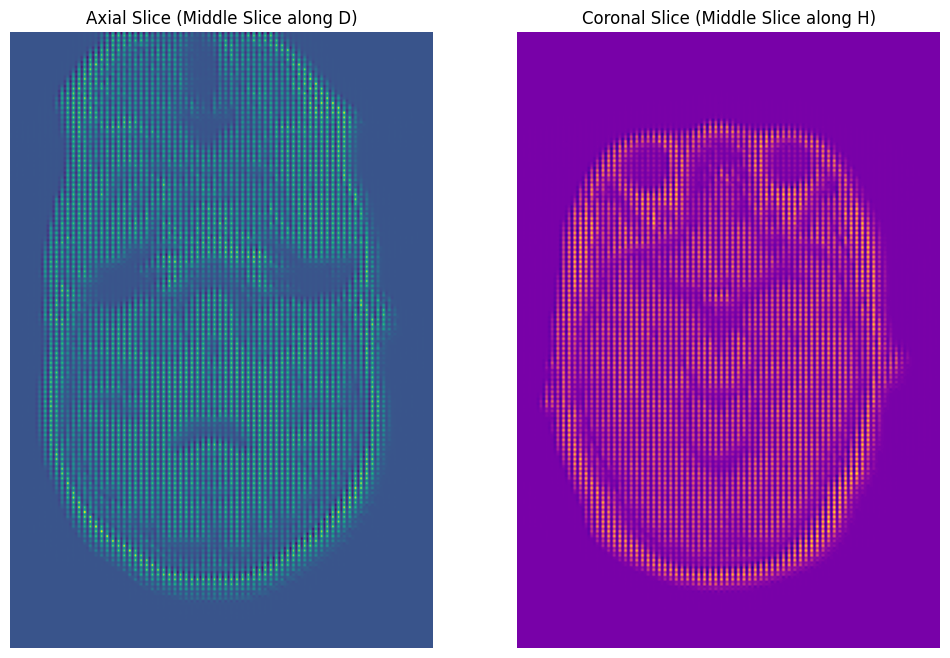

In [54]:

# Normalize and extract the middle slice
axial_middle_slice_index = axial_output.shape[2] // 2  # Middle slice along the D axis
coronal_middle_slice_index = coronal_output.shape[3] // 2  # Middle slice along the H axis

# Extract and normalize the slices
axial_slice = axial_output[0, 0, axial_middle_slice_index, :, :].cpu().detach().numpy()
coronal_slice = coronal_output[0, 0, :, coronal_middle_slice_index, :].cpu().detach().numpy()

# Normalize the slices to [0, 1] for better visualization
axial_slice = (axial_slice - np.min(axial_slice)) / (np.max(axial_slice) - np.min(axial_slice))
coronal_slice = (coronal_slice - np.min(coronal_slice)) / (np.max(coronal_slice) - np.min(coronal_slice))


# Plot both axial and coronal slices
plt.figure(figsize=(12, 8))

# Plot the axial slice
plt.subplot(1, 2, 1)
plt.imshow(axial_slice,aspect='auto')
plt.title("Axial Slice (Middle Slice along D)")
plt.axis('off')

# Plot the coronal slice
plt.subplot(1, 2, 2)
plt.imshow(coronal_slice,  cmap='plasma',aspect='auto')
plt.title("Coronal Slice (Middle Slice along H)")
plt.axis('off')

plt.show()

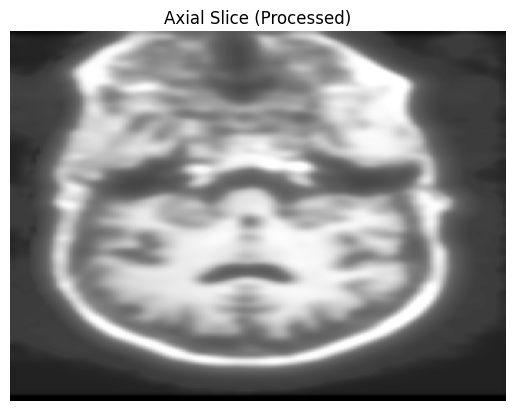

In [56]:
from scipy.ndimage import gaussian_filter
from skimage import exposure
import numpy as np

# Extract the middle slice
axial_slice = axial_output[0, 0, axial_middle_slice_index, :, :].cpu().detach().numpy()

# Step 1: Smooth the image (low-pass filter)
axial_slice_smoothed = gaussian_filter(axial_slice, sigma=2)

# Step 2: Normalize using robust percentiles
percentile_min = np.percentile(axial_slice_smoothed, 1)
percentile_max = np.percentile(axial_slice_smoothed, 99)
axial_slice_normalized = (axial_slice_smoothed - percentile_min) / (percentile_max - percentile_min)
axial_slice_normalized = np.clip(axial_slice_normalized, 0, 1)

# Step 3: Apply histogram equalization for better contrast
axial_slice_equalized = exposure.equalize_hist(axial_slice_normalized)

# Plot the result
plt.imshow(axial_slice_equalized, cmap='gray', aspect='auto')
plt.title("Axial Slice (Processed)")
plt.axis('off')
plt.show()


In [64]:
#for multiple image. 
print(axial_slice_equalized.shape)
print(axial_slice.shape)

(256, 150)
(256, 150)


In [79]:
import torch
import torch.nn.functional as F
import torch.nn as nn

class GaussianBlurLayer(nn.Module):
    def __init__(self, channels, kernel_size=5, sigma=1.0):
        super(GaussianBlurLayer, self).__init__()
        self.kernel_size = kernel_size
        self.sigma = sigma
        self.channels = channels

    def gauss_kernel(self):
        """Create a 2D Gaussian kernel."""
        x = torch.arange(-self.kernel_size // 2 + 1, self.kernel_size // 2 + 1, dtype=torch.float32)
        gauss_1d = torch.exp(-x**2 / (2 * self.sigma**2))
        gauss_1d /= gauss_1d.sum()  # Normalize
        gauss_2d = torch.outer(gauss_1d, gauss_1d)  # Create 2D kernel
        kernel = gauss_2d.expand(self.channels, 1, self.kernel_size, self.kernel_size)
        return kernel

    def forward(self, x):
        kernel = self.gauss_kernel().to(x.device)
        # Perform depthwise convolution for each channel independently
        return F.conv2d(x, kernel, stride=1, padding=self.kernel_size // 2, groups=self.channels)



In [80]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class GaussianBlurLayer(nn.Module):
    def __init__(self, kernel_size=3, sigma=1.0):
        super(GaussianBlurLayer, self).__init__()
        self.kernel_size = kernel_size
        self.sigma = sigma
        
    def gauss_kernel(self):
        """Creates a 2D Gaussian kernel."""
        size = self.kernel_size
        sigma = self.sigma
        
        x = torch.arange(-size // 2 + 1, size // 2 + 1, dtype=torch.float32)
        g = torch.exp(-x**2 / (2 * sigma**2))
        g = g / g.sum()  # Normalize the kernel
        kernel = torch.outer(g, g)  # Create 2D Gaussian kernel
        kernel = kernel.unsqueeze(0).unsqueeze(0)  # Add batch and channel dimensions
        return kernel

    def forward(self, x):
        kernel = self.gauss_kernel().to(x.device)
        return F.conv2d(x, kernel, stride=1, padding=self.kernel_size//2, groups=x.shape[1])

class UNet(nn.Module):
    def __init__(self, in_channels=1, out_channels=1, initial_filters=64):
        super(UNet, self).__init__()
        
        self.down1 = self.down_block(in_channels, initial_filters)
        self.down2 = self.down_block(initial_filters, initial_filters * 2)
        self.down3 = self.down_block(initial_filters * 2, initial_filters * 4)
        self.down4 = self.down_block(initial_filters * 4, initial_filters * 8)
        self.down5 = self.down_block(initial_filters * 8, initial_filters * 16)
        
        self.up5 = self.up_block(initial_filters * 16, initial_filters * 8)
        self.up4 = self.up_block(initial_filters * 8, initial_filters * 4)
        self.up3 = self.up_block(initial_filters * 4, initial_filters * 2)
        self.up2 = self.up_block(initial_filters * 2, initial_filters)
        self.up1 = self.up_block(initial_filters, out_channels)
        
        # Final output layer with sigmoid to constrain output
        self.final = nn.Sigmoid()

    def down_block(self, in_channels, out_channels):
        """Down-sampling block with two convolutions, batch norm, and max pooling."""
        return nn.Sequential(
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.Conv2d(out_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
   
    def up_block0(self, in_channels, out_channels):
        """Up-sampling block with bilinear upsampling and Gaussian blur."""
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            GaussianBlurLayer(kernel_size=5, sigma=1.0)
        )
    def up_block(self, in_channels, out_channels):
        """Up-sampling block with bilinear upsampling and Gaussian blur."""
        return nn.Sequential(
            nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True),
            nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.BatchNorm2d(out_channels),
            GaussianBlurLayer(channels=128, kernel_size=5, sigma=1.0) 
        )

    def forward(self, x):
        # Down-sampling path
        down1 = self.down1(x)
        down2 = self.down2(down1)
        down3 = self.down3(down2)
        down4 = self.down4(down3)
        down5 = self.down5(down4)
        
        # Up-sampling path
        up5 = self.up5(down5)
        up4 = self.up4(up5 + down4)
        up3 = self.up3(up4 + down3)
        up2 = self.up2(up3 + down2)
        up1 = self.up1(up2 + down1)
        
        # Final output layer with Sigmoid
        return self.final(up1)
# Ensure tensors are on the same device as the model (e.g., GPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Example usage
model = UNet(in_channels=1, out_channels=1, initial_filters=64)
model =model.to(device)
# Convert slices to tensors and add batch and channel dimensions
axial_tensor = torch.tensor(axial_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)
coronal_tensor = torch.tensor(coronal_slice, dtype=torch.float32).unsqueeze(0).unsqueeze(0)  # Shape: (1, 1, H, W)


axial_tensor = axial_tensor.to(device)
coronal_tensor = coronal_tensor.to(device)

# Pass axial slice through U-Net
axial_output = model(axial_tensor)  # Shape: (1, 1, 256, 256)

# Pass coronal slice through U-Net
coronal_output = model(coronal_tensor)# Shape: (1, 1, 256, 256)

# Detach the outputs and convert to numpy arrays for visualization
axial_output_np = axial_output.cpu().detach().numpy().squeeze()
coronal_output_np = coronal_output.cpu().detach().numpy().squeeze()
# Plot original and output slices side by side
plt.figure(figsize=(12, 8))

# Plot the original axial slice
plt.subplot(2, 2, 1)
plt.imshow(axial_slice, cmap='gray', aspect='auto')
plt.title("Original Axial Slice")
plt.axis('off')

# Plot the corrected axial slice
plt.subplot(2, 2, 2)
plt.imshow(axial_output_np, cmap='gray', aspect='auto')
plt.title("Corrected Axial Slice (U-Net Output)")
plt.axis('off')

# Plot the original coronal slice
plt.subplot(2, 2, 3)
plt.imshow(coronal_slice, cmap='plasma', aspect='auto')
plt.title("Original Coronal Slice")
plt.axis('off')

# Plot the corrected coronal slice
plt.subplot(2, 2, 4)
plt.imshow(coronal_output_np, cmap='plasma', aspect='auto')
plt.title("Corrected Coronal Slice (U-Net Output)")
plt.axis('off')

plt.tight_layout()
plt.show()


TypeError: GaussianBlurLayer.__init__() got an unexpected keyword argument 'channels'